# Analysis in MNE-NIRS

[MNE-NIRS](https://mne.tools/mne-nirs/stable/index.html) and the general [MNE](https://mne.tools/stable/index.html) ecosystem have nice documentation.

The most helpful way to get started is to work through the various [examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html) on the MNE-NIRS website. The [API](https://mne.tools/mne-nirs/stable/api.html) has detailed documentation and is a good overview of the capabilities of the toolbox.

In particular, have a look at the [loading data](https://mne.tools/mne-nirs/stable/auto_examples/general/plot_01_data_io.html#sphx-glr-auto-examples-general-plot-01-data-io-py), [subject-level GLM analysis](https://mne.tools/mne-nirs/stable/auto_examples/general/plot_11_hrf_measured.html#sphx-glr-auto-examples-general-plot-11-hrf-measured-py) and [group-level analysis](https://mne.tools/mne-nirs/stable/auto_examples/general/plot_12_group_glm.html#sphx-glr-auto-examples-general-plot-12-group-glm-py).

# Loading data

Here we will load a single file from our dataset and inspect it.

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_nirs
import mne_bids
from nilearn.plotting import plot_design_matrix
from itertools import compress
from collections import defaultdict

# Let's load an example SNIRF file.
snirf_path = "../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-01/nirs/sub-01_task-tapping_nirs.snirf"
raw = mne.io.read_raw_snirf(snirf_path)
print(f"Raw file object: {raw}")

# Metadata about the file is stored in the info structure.
# We have sampling frequenct in sfreq, channels and names in chs/ch_names.
print("\nMetadata\n")
info = raw.info
print(info)

# We also have our stimuli / events
# In this case, 30 events each of:
# control, left tapping, or right tapping.
annotations = raw.annotations
print(annotations)

# Let's give them some nicer names and delete the start/stop marker.
raw.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
raw.annotations.delete(raw.annotations.description == "15.0")
raw.annotations.set_durations(5)

Loading C:\Users\alkvis\OneDrive - Karolinska Institutet\Dokument\Project\uMOVE\NEMES_2025\nemes_workshop_2025\MNE_pipeline\..\data\rob-luke-BIDS-NIRS-Tapping-e262df8\sub-01\nirs\sub-01_task-tapping_nirs.snirf
Raw file object: <RawSNIRF | sub-01_task-tapping_nirs.snirf, 56 x 23239 (2974.5 s), ~70 kB, data not loaded>

Metadata

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S1_D3 760, S1_D3 ...
 chs: 56 fNIRS (CW amplitude)
 custom_ref_applied: False
 dig: 31 items (3 Cardinal, 28 EEG)
 highpass: 0.0 Hz
 lowpass: 3.9 Hz
 meas_date: 2020-01-01 13:16:16 UTC
 nchan: 56
 projs: []
 sfreq: 7.8 Hz
 subject_info: 4 items (dict)
>
<Annotations | 92 segments: 1.0 (30), 15.0 (2), 2.0 (30), 3.0 (30)>


<Annotations | 90 segments: Control (30), Tapping/Left (30), Tapping/Right ...>

# Visualize montage

Let's have a look at the channels and montage.

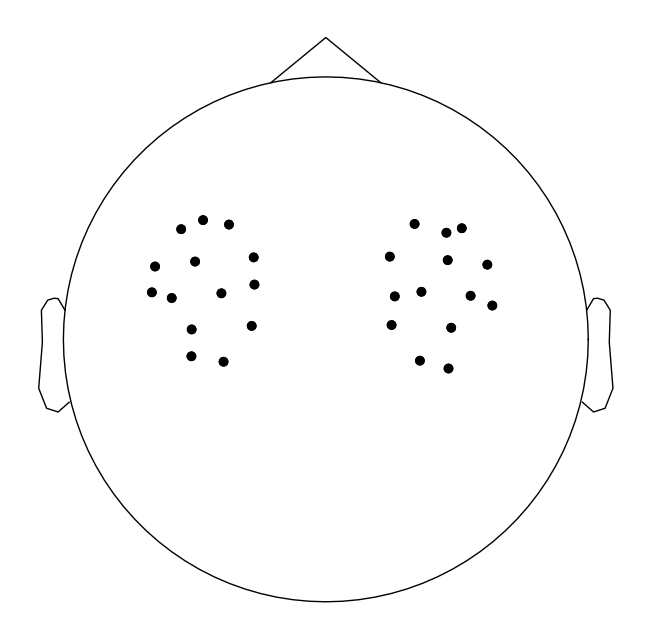

Channel types::	fnirs_cw_amplitude: 56


C:\Users\alkvis\OneDrive - Karolinska Institutet\Dokument\Project\uMOVE\NEMES_2025\nemes_workshop_2025\MNE_pipeline\mne_workshop\lib\site-packages\mne\viz\backends\_pyvista.py:588: PyVistaDeprecationWarning: 
mne_workshop/lib/site-packages/mne/viz/backends/_pyvista.py:588: Argument 'radius' must be passed as a keyword argument to function 'PolyDataFilters.tube'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  tube = line.tube(radius, n_sides=self.tube_n_sides)


In [43]:
# The list in info['chs'] contains information about 
# channels, their position, name, unit, etc.
# Let's use a toolbox function to plot them.
raw.plot_sensors()

# Since the sensors are in a 3D space, the 2D plot doesn't look
# that good. Let's instead plot them on a template brain in 3D.
subjects_dir = str(mne.datasets.sample.data_path()) + '/subjects'
brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5")
brain.add_sensors(raw.info, trans="fsaverage", fnirs=["channels", "pairs", "sources", "detectors"])
brain.show_view(azimuth=180, elevation=80, distance=450)

# Visualize raw data

We will plot the raw light intensity data.

We can see each condition marked in the time series.

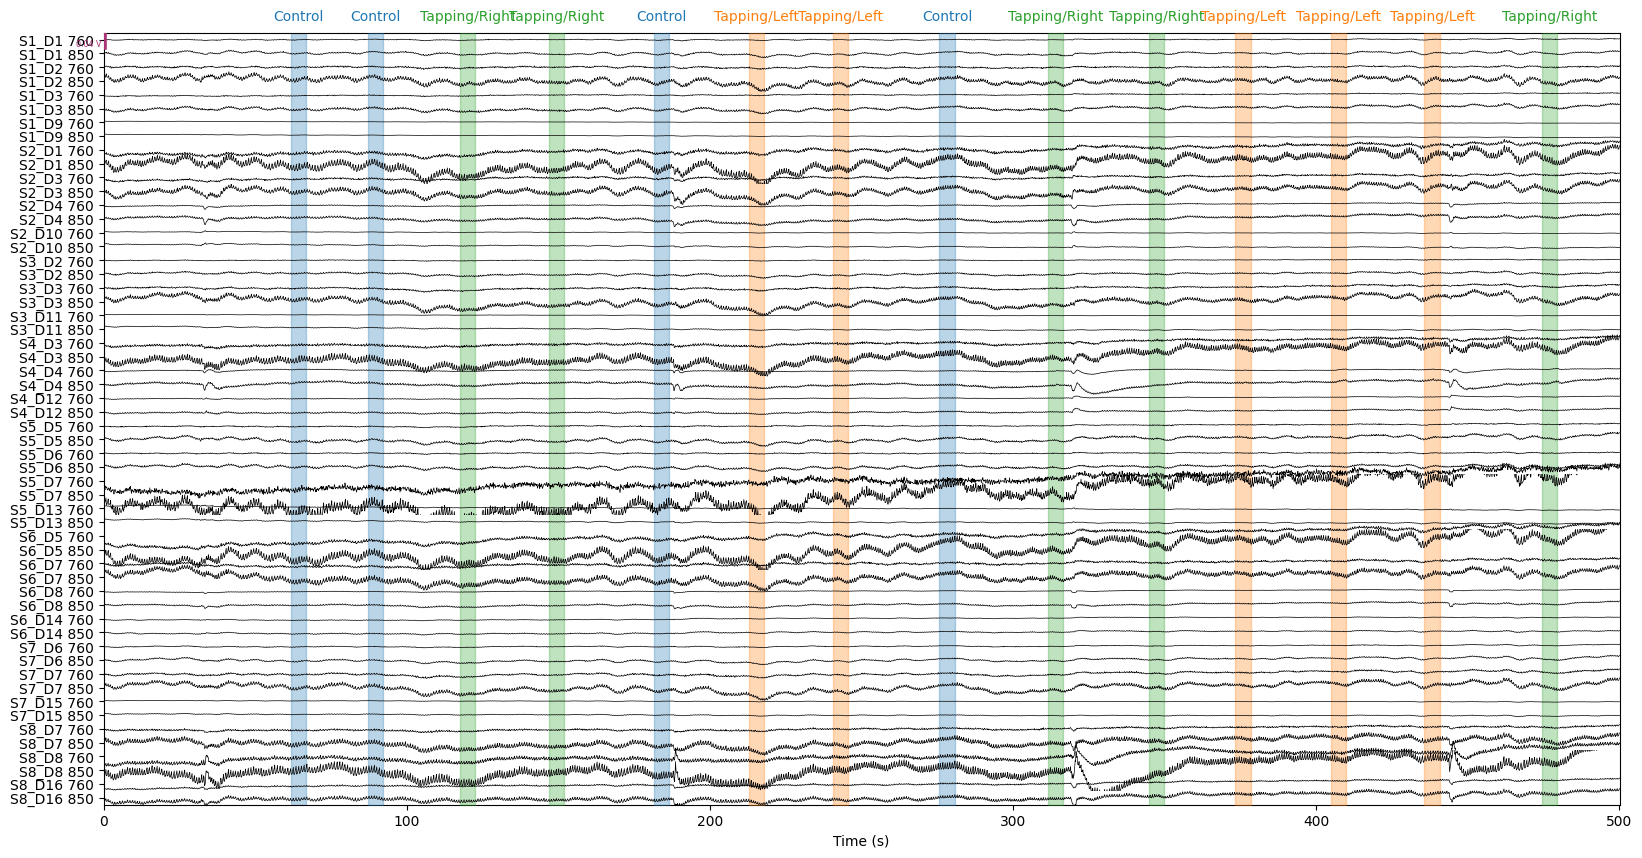

In [44]:
# Plot the raw intensity data. If you're not using a notebook, you can set 
# scrollbars to True and scroll through all the data.
raw.plot(n_channels=len(raw.ch_names), duration=500, show_scrollbars=False)
pass

# Inspect quality

We will use the Scalp Coupling Index (SCI) to evaluate channel quality.

First, we need to convert raw intensity to optical density (OD). Then we calculate SCI on the OD data.

We see that, using criteria SCI < 0.7 for a bad channel, for example S1-D9 and S5-D5 are bad through most of the experiment (for sub-01).

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Bad channels with SCI < 0.7:
['S1_D1 760', 'S1_D1 850', 'S1_D9 760', 'S1_D9 850', 'S3_D2 760', 'S3_D2 850', 'S5_D5 760', 'S5_D5 850', 'S5_D7 760', 'S5_D7 850']


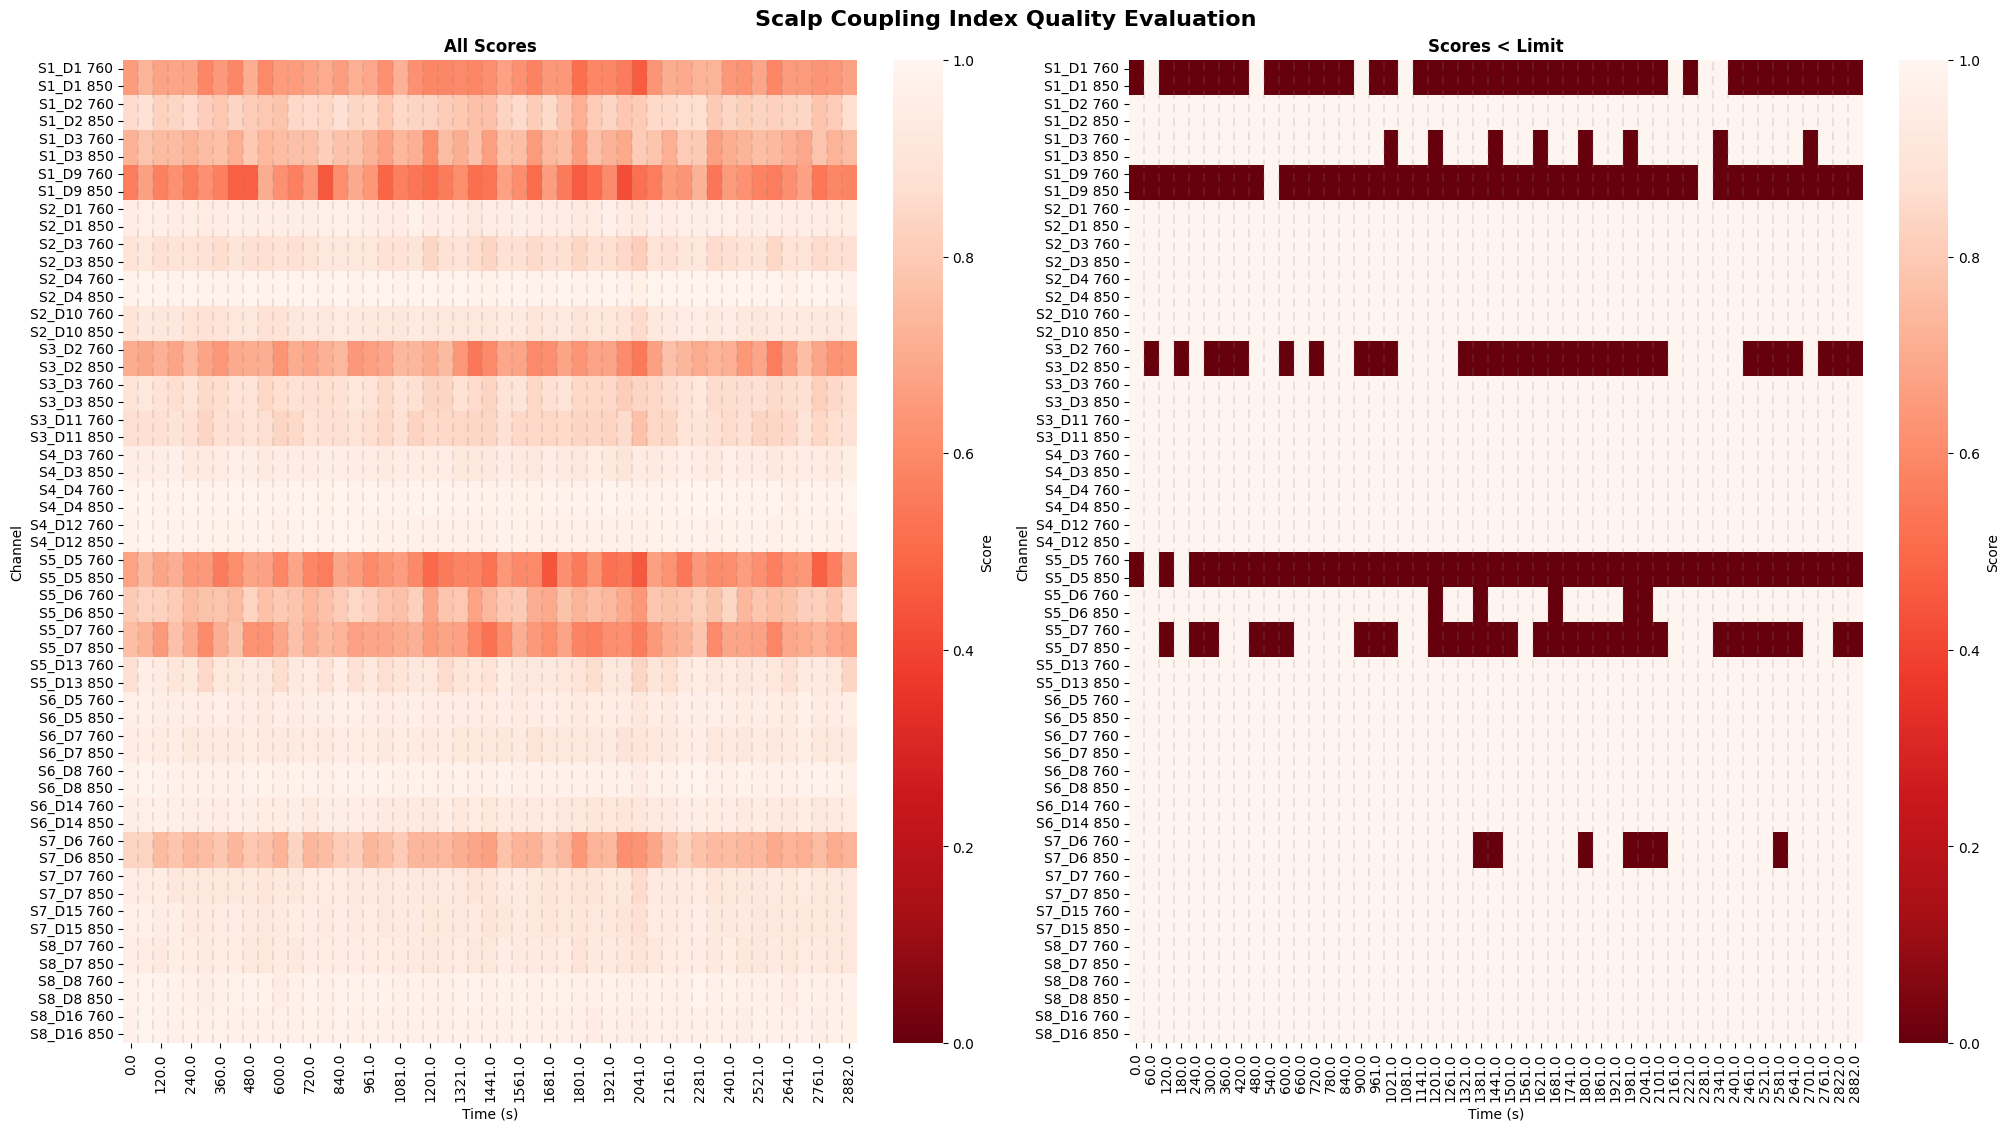

In [45]:
raw_od = mne.preprocessing.nirs.optical_density(raw)

_, scores, times = mne_nirs.preprocessing.scalp_coupling_index_windowed(raw_od, time_window=60)
mne_nirs.visualisation.plot_timechannel_quality_metric(
    raw_od,
    scores,
    times,
    threshold=0.7,
    title="Scalp Coupling Index " "Quality Evaluation",
)

# We can also calculate them over the full signal and store overall bad channel in the info object's 'bads' dict.
sci_limit = 0.7
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < sci_limit))
print(f"Bad channels with SCI < {sci_limit}:")
print(raw_od.info["bads"])

# Convert to hemoglobin data using mBLL

Now we convert OD to HbO (oxygenated hemoglobin) and HbR (deoxygenated hemoglobin).

Notice that the channels marked as bad are greyed out in the time series plot.

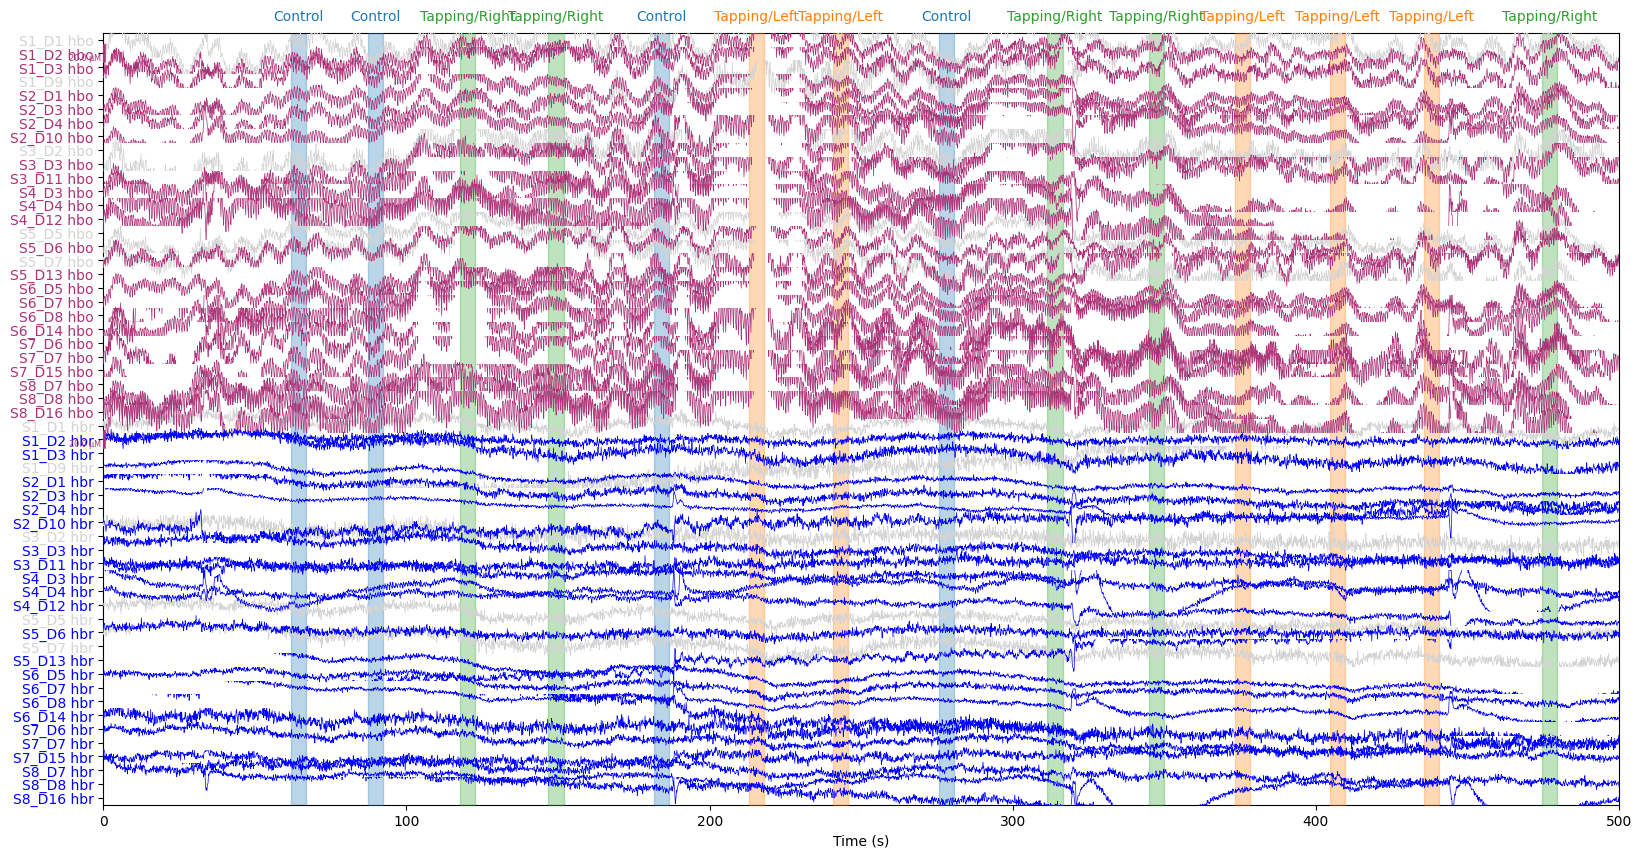

In [46]:
# Convert to hemoglobin
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

# Plot hemoglobin
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)
pass

# Simple waveform

Altough not the most sophisticated analysis, let's calculate a very simple block average of the hemoglobin data and look at the waveform.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Used Annotations descriptions: [np.str_('Control'), np.str_('Tapping/Left'), np.str_('Tapping/Right')]
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.0s finished


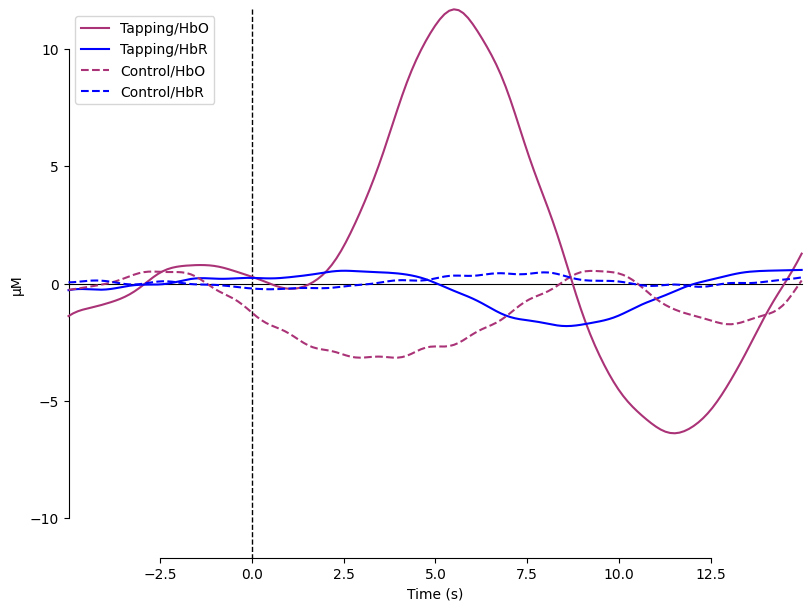

[<Figure size 800x600 with 1 Axes>]

In [47]:
# Filter out the heartbeat frequency and slow drifts with a bandpass filter
raw_haemo_filt = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
events, event_dict = mne.events_from_annotations(raw_haemo_filt)

# Reject epochs with huge spikes in the data
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

# Epoch the data
epochs = mne.Epochs(
    raw_haemo_filt,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=False,
)

# What shall we plot?
# This will be both Tapping/Left and Tapping/Right compared to Control.
evoked_dict = {
    "Tapping/HbO": epochs["Tapping"].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"].average(picks="hbr"),
    "Control/HbO": epochs["Control"].average(picks="hbo"),
    "Control/HbR": epochs["Control"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

# Plot the epochs
color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Control=dict(linestyle="dashed"))
mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

# GLM analysis

A better approach, generally, is to use GLM analysis rather than block averaging.

We will:

- Run the preprocessing
- Create a design matrix with drift and short-channel regressors
- Plot the design matrix
- Run the GLM
- Print the results, with GLM estimate (theta/beta), t-val, p-val, for each channel and condition.

Loading C:\Users\alkvis\OneDrive - Karolinska Institutet\Dokument\Project\uMOVE\NEMES_2025\nemes_workshop_2025\MNE_pipeline\..\data\rob-luke-BIDS-NIRS-Tapping-e262df8\sub-01\nirs\sub-01_task-tapping_nirs.snirf
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


C:\Users\alkvis\AppData\Local\Temp\ipykernel_21864\2835491582.py:47: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  fig = plot_design_matrix(design_matrix, ax=ax1)


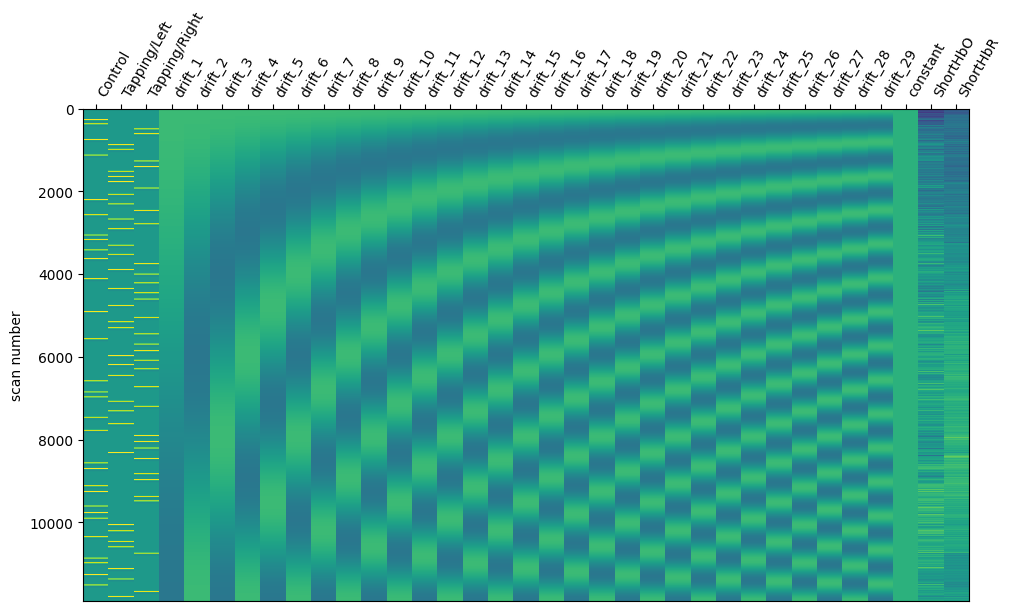

Solving GLM...
Result
variable      Condition      df    mse  p_value     se        t   theta  \
0               Control 35.0000 0.0000   0.8123 0.0000   0.2392  0.0000   
1              ShortHbO 35.0000 0.0000   0.0000 0.0051 117.6586  0.6013   
2              ShortHbR 35.0000 0.0000   0.0000 0.0255  -6.0113 -0.1534   
3          Tapping/Left 35.0000 0.0000   0.0000 0.0000  12.2717  0.0000   
4         Tapping/Right 35.0000 0.0000   0.0000 0.0000  21.2176  0.0000   

variable  Source  Detector Chroma  Significant    ch_name  
0              1         1    hbo        False  S1_D1 hbo  
1              1         1    hbo         True  S1_D1 hbo  
2              1         1    hbo         True  S1_D1 hbo  
3              1         1    hbo         True  S1_D1 hbo  
4              1         1    hbo         True  S1_D1 hbo  


In [5]:
from nilearn.plotting import plot_design_matrix

# Let's re-read the file and preprocess it.
snirf_path = "../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-01/nirs/sub-01_task-tapping_nirs.snirf"
raw = mne.io.read_raw_snirf(snirf_path)

raw.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
raw.annotations.delete(raw.annotations.description == "15.0")
raw.annotations.set_durations(5)

# Raw to OD
raw_od = mne.preprocessing.nirs.optical_density(raw)

# SCI limit
sci_limit = 0.7
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < sci_limit))

# OD to Hb
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

# Let's resample down to 4 for speed
raw_haemo.resample(4)

# Separate long and short channels
short_chans = mne_nirs.channels.get_short_channels(raw_haemo)
long_chans = mne_nirs.channels.get_long_channels(raw_haemo)

# Create the design matrix from events, long channel data,
# drift regressors, as well as (mean) short channel data as regressors
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(
    long_chans,
    drift_model="cosine",
    high_pass=0.005,  # Must be specified per experiment
    hrf_model="spm",
    stim_dur=5.0,
)

# Append short channels to design matrix
design_matrix["ShortHbO"] = np.mean(short_chans.copy().pick(picks="hbo").get_data(), axis=0)
design_matrix["ShortHbR"] = np.mean(short_chans.copy().pick(picks="hbr").get_data(), axis=0)

# Plot our resulting design matrix
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)
plt.show()

# Then let's run the GLM with this design matrix
print("Solving GLM...")
glm_est = mne_nirs.statistics.run_glm(long_chans, design_matrix, noise_model="auto")

# Print output nicely
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.4f}".format

print("Result")
print(glm_est.to_dataframe().head())

# Full pipeline using the full BIDS dataset

We can use MNE-BIDS to load the full dataset.

In [8]:
def individual_analysis(raw_haemo, plot_design=False):

    # Cut out just the short channels for creating a GLM repressor
    short_chans = mne_nirs.channels.get_short_channels(raw_haemo)
    long_chans = mne_nirs.channels.get_long_channels(raw_haemo)

    # Create a design matrix
    design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(
        long_chans,
        drift_model="cosine",
        high_pass=0.005,  # Must be specified per experiment
        hrf_model="spm",
        stim_dur=5.0,
    )

    # Append short channels to design matrix
    design_matrix["ShortHbO"] = np.mean(short_chans.copy().pick(picks="hbo").get_data(), axis=0)
    design_matrix["ShortHbR"] = np.mean(short_chans.copy().pick(picks="hbr").get_data(), axis=0)

    # Run GLM
    print("Solving GLM..")
    glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix, noise_model="auto")

    if plot_design:
        fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
        fig = plot_design_matrix(design_matrix, ax=ax1)
        plt.show()

    return glm_est, design_matrix



# Specify BIDS root folder
bids_root = "../data/rob-luke-BIDS-NIRS-Tapping-e262df8"

# We have 4 data types: events, channels, optodes, and nirs.
# We will load the nirs, which corresponds to the SNIRF file.
# The other are types are the sidecar JSON files.
datatype = 'nirs'
bids_path = mne_bids.BIDSPath(root=bids_root, datatype=datatype)
nirs_files = bids_path.match()

# Prepare params
task = 'tapping'
suffix = 'nirs'

# Get all subjects in a sorted list
all_subjects = [file.subject for file in nirs_files]
all_subjects = sorted(list(set(all_subjects)))
print("Subjects")
print(all_subjects)

# Prepare folder for processed data
glm_folder = "glm_data"
if not os.path.isdir(glm_folder):
    os.mkdir(glm_folder)

# Print output nicely
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.4f}".format

# Go through data for each subject
cha_frames = []
for subject in all_subjects:

    # Find the SNIRF file for this subject
    bids_path = mne_bids.BIDSPath(subject=subject, task=task,
                            suffix=suffix, datatype=datatype,
                            root=bids_root)

    print("Using BIDS file path..")
    print(bids_path)

    # Load the SNIRF file and convert to optical density
    raw_intensity = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

     # Calculate the scalp coupling index (SCI) and mark
    # bad quality channels in the data
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < sci_limit))
    print(f"Bad channels with SCI < {sci_limit}:")
    print(raw_od.info["bads"])

    # Apply TDDR
    raw_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od)

    # Use the MBLL to convert into hemoglobin changes
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo.resample(4)

    # Run the GLM analysis
    glm_fname = f"{glm_folder}/{subject}_glm.h5"
    glm_est, design_matrix = individual_analysis(raw_haemo, plot_design=False)
    
    # You can save GLM results in HDF5 form like this if you want
    #glm_est.save(glm_fname, overwrite=True)

    # Append results per channel and ROI to larger dataframe for later export
    cha = glm_est.to_dataframe()
    cha['subject'] = subject
    cha_frames.append(cha)

cha_data = pd.concat(cha_frames, ignore_index=True)
cha_data.to_csv("glm_data/cha_data.csv")
print('done')


Subjects
['01', '02', '03', '04', '05']
Using BIDS file path..
../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-01/nirs/sub-01_task-tapping_nirs.snirf
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Bad channels with SCI < 0.7:
['S1_D1 760', 'S1_D1 850', 'S1_D9 760', 'S1_D9 850', 'S3_D2 760', 'S3_D2 850', 'S5_D5 760', 'S5_D5 850', 'S5_D7 760', 'S5_D7 850']
Solving GLM..
Using BIDS file path..
../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-02/nirs/sub-02_task-tapping_nirs.snirf
Reading 0 ... 18877  =      0.000 ...  2416.256 secs...
Bad channels with SCI < 0.7:
['S1_D1 760', 'S1_D1 850', 'S1_D3 760', 'S1_D3 850', 'S5_D6 760', 'S5_D6 850', 'S5_D7 760', 'S5_D7 850', 'S6_D7 760', 'S6_D7 850', 'S7_D6 760', 'S7_D6 850']
Solving GLM..
Using BIDS file path..
../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-03/nirs/sub-03_task-tapping_nirs.snirf
Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
Bad channels with SCI < 0.7:
['S1_D1 760', 'S1_D1 850', 'S1_D2 760', 'S1_D2 850', 'S1_D3 76

# Read and visualize GLM group level results

We will read the previously saved GLM channel-level results, run a mixed model on group level, and visualize the results.

   Unnamed: 0     Condition    df           mse       p_value            se  \
0           0          15.0  36.0  1.341901e-11  2.614177e-01  3.785438e-06   
1           1       Control  36.0  1.341901e-11  8.371403e-01  7.891191e-07   
2           2      ShortHbO  36.0  1.341901e-11  6.646174e-47  5.361535e-03   
3           3      ShortHbR  36.0  1.341901e-11  2.714681e-04  2.580814e-02   
4           4  Tapping/Left  36.0  1.341901e-11  1.241223e-13  7.921721e-07   

            t         theta  Source  Detector Chroma  Significant    ch_name  \
0    1.140966  4.319054e-06       1         1    hbo        False  S1_D1 hbo   
1    0.207046  1.633843e-07       1         1    hbo        False  S1_D1 hbo   
2  108.590070  5.822095e-01       1         1    hbo         True  S1_D1 hbo   
3   -4.035885 -1.041587e-01       1         1    hbo         True  S1_D1 hbo   
4   11.520822  9.126473e-06       1         1    hbo         True  S1_D1 hbo   

   subject  
0        1  
1        1  
2    

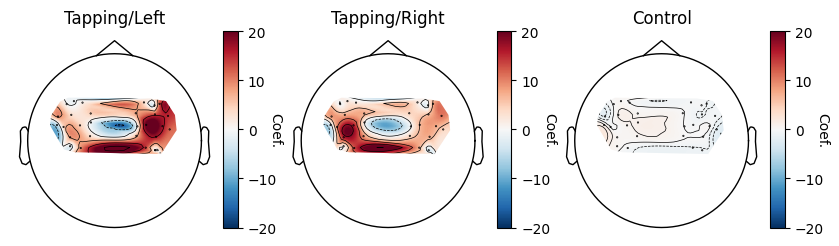

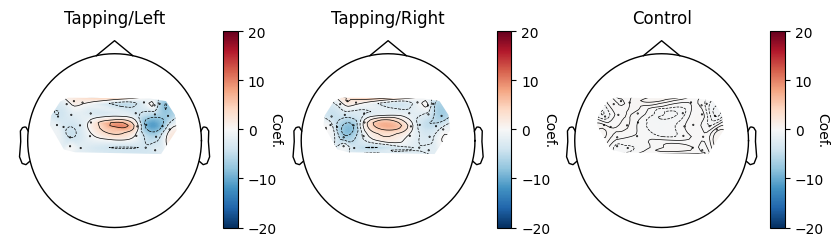

In [14]:
import statsmodels.formula.api as smf

# Let's read the file we saved..
ch_data = pd.read_csv("glm_data/cha_data.csv")
print(ch_data.head())

# Read a SNIRF (just for montage and channel names)
snirf_path = "../data/rob-luke-BIDS-NIRS-Tapping-e262df8/sub-01/nirs/sub-01_task-tapping_nirs.snirf"
raw_intensity = mne.io.read_raw_snirf(snirf_path)
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

# Get data from the channel level frame
ch_summary_hbo = ch_data.query("Condition in ['Tapping/Left', 'Tapping/Right', 'Control']")
ch_summary_hbo = ch_summary_hbo.copy()
ch_summary_hbo["theta"] = [t * 1.e6 for t in ch_summary_hbo["theta"]] # Convert unit for nicer plotting
ch_summary_hbo = ch_summary_hbo.query("Chroma in ['hbo']")

# Run group level mixed model and convert to dataframe
ch_model_hbo = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                    ch_summary_hbo, groups=ch_summary_hbo["subject"]).fit(method='nm')
ch_model_df_hbo = mne_nirs.statistics.statsmodels_to_results(ch_model_hbo, order=raw_haemo.copy().pick("hbo").ch_names)

# One for HbR
ch_summary_hbr = ch_data.query("Condition in ['Tapping/Left', 'Tapping/Right', 'Control']")
ch_summary_hbr = ch_summary_hbr.copy()
ch_summary_hbr["theta"] = [t * 1.e6 for t in ch_summary_hbr["theta"]] # Convert unit for nicer plotting
ch_summary_hbr = ch_summary_hbr.query("Chroma in ['hbr']")
ch_model_hbr = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                    ch_summary_hbr, groups=ch_summary_hbr["subject"]).fit(method='nm')
ch_model_df_hbr = mne_nirs.statistics.statsmodels_to_results(ch_model_hbr, order=raw_haemo.copy().pick("hbr").ch_names)

# Plot 2D 
conditions = ['Tapping/Left', 'Tapping/Right', 'Control']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10),
                        gridspec_kw=dict(width_ratios=[1, 1, 1]))  # 3 values for 3 columns

for idx, cond in enumerate(conditions):
    mne_nirs.visualisation.plot_glm_group_topo(
        raw_haemo.copy().pick(picks="hbo"),
        ch_model_df_hbo.query(f"Condition in ['{cond}']"),
        colorbar=True, axes=axes[idx],
        vlim=(-20, 20)
    )
plt.show()


conditions = ['Tapping/Left', 'Tapping/Right', 'Control']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10),
                        gridspec_kw=dict(width_ratios=[1, 1, 1]))  # 3 values for 3 columns

for idx, cond in enumerate(conditions):
    mne_nirs.visualisation.plot_glm_group_topo(
        raw_haemo.copy().pick(picks="hbr"),
        ch_model_df_hbr.query(f"Condition in ['{cond}']"),
        colorbar=True, axes=axes[idx],
        vlim=(-20, 20)
    )
plt.show()